# Pryngles module: System

In [1]:
from pryngles import *

## External modules

In [2]:
import rebound as rb

## Aliases

In [3]:
sci=Science
print_df=Misc.print_df

## System Class

This is the most important class in the whole package.  This class allows to create the planetary system and manipulate it.

In [4]:
System_doc=\
f"""Creates a planetary system.

    Initialization attributes:

        units: list of strings, default = ['au','msun','yr']:
            Units used in calculations following the conventions and signs of rebound.
            The order SHOULD always be MKS: length, mass, time (in that order)

    Optional attributes:

        resetable: boolean, default = False:
            If True the system is resetable, namely you can reset it to the initial system.
            
        filename: string, default = None:
            File to load system.

    Derived attributes:

        sim: Class Simulation:
            Rebound Simulation object.

        ul, um, ut: float [SI units]:
            Value of the conversion factors for each unit.

        G: float [ul^3/ut^2/um]
            Value of the gravitational constant.

        bodies: dictionary:
            Bodies in the system.

        sources: dictionary:
            Bodies in the system which are sources of light.

        nbodies: int:
            Number of bodies.

        nsources: int:
            Number of sources of light.

        nparticles: int:
            Numbre of particles in rebound simulation.

        spangler: Class Spangler:
            Spangler object with all the spangles in the system.

    Examples:

        #Create a system
        sys=System(units=["au","msun","yr"])
        sys.sim.integrator='whfast'
        sys.sim.dt=0.01

        #Add star (by default, m = 1)
        S=sys.add()

        #Add planet, when an object is added, it is automatically spangled
        P=sys.add("Planet",radius=0.1,m=1e-3,a=1,e=0.2)

        #Add moon: orbital elements are respect to ecliptic system
        M=sys.add("Planet",primary=P,radius=0.01,m=1e-7,a=0.1,e=0.01)

        #Add ring system
        R=sys.add("Ring",primary=P,fi=1.5,fe=2.5,albedo_gray_normal=0.5,tau_gray_optical=3)

""";

In [5]:
class System(PrynglesCommon):
    
    def __init__(self,
                 filename=None,
                 units=['au','msun','yr'],
                 resetable=False
                ):
        
        if filename:
            self.load_from(filename)
            return
        
        #Rebound simulation
        self.sim=rb.Simulation()
        
        #Attributes by default
        self.bodies=dict()
        self.sources=dict()
        
        #Observer properties
        self.n_obs=[0,0,1]
        self.alpha_obs=0  
        
        #Check if spangled
        self._spangled=False

        #Initialize spangler object
        self.sg=None
        
        #Is the system resetable?
        self._resetable=resetable
        if self._resetable:
            #Create temporary file
            self._snap_file_name = "/tmp/pryngles-system.pkl"
        
        #Update rebound units
        self.update_units(units)
        
    def update_units(self,units):
        """Update units of the system
        """
        self.units=units
        
        #Units
        self._ul,self._um,self._ut=self.units
        self.sim.units=self.units
        
        #Canonical units of the system
        self.ul=rb.units.convert_length(1,self._ul,"m")
        self.um=rb.units.convert_mass(1,self._um,"kg")
        self.ut=np.sqrt(self.sim.G*self.ul**3/(self.um*GSI))
        
        #Update system
        self._update_system()
        
    def _update_system(self):
        """Update system properties
        """
        self.nbodies=len(self.bodies)
        self.nsources=len(self.sources)
        self.nparticles=len(self.sim.particles)
        
    def _is_spangled(self):
        return True if self.sg else False
        
    def save_to(self,filename):
        """Save system from file
        
        Parameters:
            filename: string:
                Path to file where the object will be pickled.
                
        Result:
            File 'filename' for regular object and 'filename.rbin' for rebound simulation
        """
        #Rebound file
        rb_filename=filename+".rbin"

        #Save rebound state
        verbose(VERB_SIMPLE,"Saving rebound simulation")
        self.sim.save(rb_filename)

        #Since rebound have ctypes it cannot be pickled
        del self.sim

        #Pickle system
        PrynglesCommon.save_to(self,filename)

        #Load again rebound
        self.sim=rb.Simulation(rb_filename)

    def load_from(self,filename):
        """Load system from filename
                
        Parameters:
            filename: string:
                Path to file where the object will be pickled.
                There to be 2 files: 'filename' (with the regular object) and filename.rbin with 
                rebound simulation.
        """
        #Rebound file
        rb_filename=filename+".rbin"

        #Load system
        self=PrynglesCommon.load_from(self,filename)

        #Load rebound
        verbose(VERB_SIMPLE,"Loading rebound simulation")
        self.sim=rb.Simulation(rb_filename)
        
    def status(self):
        print(f"System with {self.nbodies} bodies, {self.nsources} sources and {self.nparticles} particles")
        sys.sim.status()

System.__doc__=System_doc

In [6]:
if IN_JUPYTER:
    def test_system_init(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        sys=System(resetable=True)
        print("Nbodies = ",sys.nbodies)
        print("G constant = ",sys.sim.G)
        print("G constant = ",sys.units)
        print("Canonical units = ",sys.ul,sys.um,sys.ut)
        
        sys=System(units=['m','kg','s'])
        print("Nbodies = ",sys.nbodies)
        print("G constant = ",sys.sim.G)
        print("G constant = ",sys.units)
        print("Canonical units = ",sys.ul,sys.um,sys.ut)
        print(sys)
        
        sys.save_to("/tmp/system.pkl")
        print(sys.sim.status())
        sys2=System("/tmp/system.pkl")
        print(sys2.sim.status())
        
        print(sys.sim.N)

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_system_init=test_system_init
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.

Nbodies =  0
G constant =  39.476926421373
G constant =  ['au', 'msun', 'yr']
Canonical units =  149597870700.0 1.9884754159665356e+30 31557600.0
Nbodies =  0
G constant =  6.67408e-11
G constant =  ['m', 'kg', 's']
Canonical units =  1.0 1.0 1.0
{'sim': <rebound.simulation.Simulation object at 0x7fe069694e40, N=0, t=0.0>, 'bodies': {}, 'sources': {}, 'n_obs': [0, 0, 1], 'alpha_obs': 0, 'sg': None, 'units': ['m', 'kg', 's'], 'ul': 1.0, 'um': 1.0, 'ut': 1.0, 'nbodies': 0, 'nsources': 0, 'nparticles': 0}
  VERB1::save_to:: Saving rebound simulation
    VERB2::save_to:: Saving object to /tmp/system.pkl
---------------------------------
REBOUND version:     	3.19.3
REBOUND built on:    	May  7 2022 18:49:54
Number of particles: 	0
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
None
    VERB2::load_from:: Loading object from /tmp/system.pkl
      VERB3::load_from:: Transferring data to new object
  VE


----------------------------------------------------------------------
Ran 1 test in 0.130s

OK


In [7]:
def add(self,kind="Star",primary=None,center="primary",**props):
    """Add an object to the system
    
    Examples:
    
        sys=System()
        S=sys.add("Star",m=2)
    
    Parameters:
    
        kind: string, default = "Star":
            Kind of object: Star, Planet, Ring (see BODY_KINDS).
    
        primary: Body, default = None:
            Primary object of the body.
            
        center: string, default = "primary":
            Center with respect to the positions are indicated.  
            Possible values: "primary", "inertial".
            When "inertial" you can provide positions of the objects using cartesian
            coordinates.

        props: dictionary:
            List of properties of the body.
            
    Returns:
        
        Body
            Body added to the system.
            
    Examples:
        #Add star (by default, m = 1)
        S=sys.add()

        #Add planet, when an object is added, it is automatically spangled
        P=sys.add("Planet",radius=0.1,m=1e-3,a=1,e=0.2)

        #Add moon: orbital elements are respect to ecliptic system
        M=sys.add("Planet",primary=P,radius=0.01,m=1e-7,a=0.1,e=0.01)

        #Add ring system
        R=sys.add("Ring",primary=P,fi=1.5,fe=2.5,albedo_gray_normal=0.5,tau_gray_optical=3)        
        
    """
    if kind is None:
        raise AssertionError("You must provide a valid object kind (Star, Planet, Ring).")

    if kind not in BODY_KINDS:
        raise ValueError(f"Object kind '{kind}' is not recognized.")

    #Create body
    exec(f"self.__body={kind}(primary=primary,**props)")
    
    if self.__body.bhash in self.bodies:
        raise ValueError(f"An object with hash '{self.__body.bhash}' has been already added.")
    
    self.bodies[self.__body.bhash]=self.__body
    
    if kind == "Star":
        #Add a source
        self.sources[self.__body.bhash]=self.__body
    
    if kind == "Ring":
        
        #If it is a ring it does not need to be add to rebound
        self.__body.rbhash=self.__body.primary.rbhash
    
    else:
        
        #Add body to simulation
        rb_add_options={k:v for k,v in self.__body.__dict__.items() if k in REBOUND_ORBITAL_PROPERTIES}
        rb_add_options.update(hash=self.__body.bhash)
        
        #Check if positions are given with respect to primary
        if primary and center=="primary":
            rb_add_options.update(primary=self.sim.particles[primary.bhash])

        verbose(VERB_VERIFY,f"Adding rebound object with hash {self.__body.bhash} with center {center}")
        verbose(VERB_DEEP,f"Rebound add options {rb_add_options}")
        
        #Add particle to rebound
        self.sim.add(**rb_add_options)
        
        #self.__body.particle=self.sim.particles[self.__body.hash] <- This is not convenient for pickling
        self.__body.rbhash=self.__body.bhash

    verbose(VERB_SIMPLE,f"Object '{kind}' with hash '{self.__body.bhash}' has been added.")
    #Update system
    self._update_system()
    return self.__body
    
System.add=add

In [8]:
if IN_JUPYTER:
    def test_system_add(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        sys=System()
        S=sys.add(m=8,radius=4,x=5,vy=2)
        P=sys.add("Planet",primary=S,a=2,radius=2)
        M=sys.add("Planet",primary=P,a=2,radius=2)
        R=sys.add("Ring",primary=P,fi=1.3,fe=2.3)
        
        for particle in sys.sim.particles:
            print(particle)
            
        print(sys)
        print(sys.nbodies,sys.nparticles,sys.nsources)

        Verbose.VERBOSITY=VERB_NONE
                
    class Test(unittest.TestCase):pass    
    Test.test_system_add=test_system_add
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_star_properties:: Updating properties of Star
      VERB3::limb_darkening:: Normalization of limb darkening function for cs = [], N = 3.141592653589793
      VERB3::add:: Adding rebound object with hash 8787545616845 with center primary
        VERB4::add:: Rebound add options {'m': 8, 'x': 5, 'vy': 2, 'hash': '8787545616845'}
  VERB1::add:: Object 'Star' with hash '8787545616845' has been added.
      VERB3::_update_childs:: Add child 8787545226972 to body Star (8787545616845)
      VERB3::_update_primary:: Add primary 8787545616845 to body Planet (8787545226972)
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::update_planet:: Updating Planet
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_planet_properties:: Updating Plan

.

  VERB1::add:: Object 'Planet' with hash '8787545616833' has been added.
      VERB3::_update_childs:: Add child 8787545616827 to body Planet (8787545226972)
      VERB3::_update_primary:: Add primary 8787545226972 to body Ring (8787545616827)
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::update_ring:: Updating Ring
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_ring_properties:: Updating Ring properties
  VERB1::add:: Object 'Ring' with hash '8787545616827' has been added.
<rebound.particle.Particle object at 0x7fe028388840, m=8.0 x=5.0 y=0.0 z=0.0 vx=0.0 vy=2.0 vz=0.0>
<rebound.particle.Particle object at 0x7fe028926340, m=1.0 x=7.0 y=0.0 z=0.0 vx=0.0 vy=15.32839708652839 vz=0.0>
<rebound.particle.Particle object at 0x7fe028388840, m=1.0 x=9.0 y=0.0 z=0.0 vx=0.0 vy=21.61146372801589 vz=0.0>
{'sim': <rebound.simulation.Simulation object at 


----------------------------------------------------------------------
Ran 1 test in 0.332s

OK


In [9]:
def remove(self,bhash):
    """Remove a body from a system.

    Parameters:
        bhash: string
            Hash of the body to remove
    
    Notes: 
        Remove eliminate body and all the childs and the childs of the childs.

    Example:
        sys=System()
        S=sys.add(m=2)
        sys.remove(bhash=S.bhash)
    """
    
    if bhash in self.bodies:
        verbose(VERB_SIMPLE,f"Removing object {bhash} from system")

        obj=self.bodies[bhash]

        #Get the list of child hashes before removing (it changes during for)
        child_hashes=list(obj.childs.keys())
        
        #Remove child objects
        for child_hash in child_hashes:
            if child_hash in self.bodies:
                self.remove(child_hash)
                
        #Remove object from simulation
        if obj.kind != "Ring":
            verbose(VERB_SIMPLE,f"Removing particle {bhash} from simulation")
            self.sim.remove(hash=bhash)
        
        #Remove object from childs of its primary
        if obj.primary:
            del obj.primary.childs[bhash]
        
        #Remove object from bodies
        del self.bodies[bhash]

        #Update system
        self._update_system()
    else:
        raise ValueError(f"No object with hash '{bhash}' in the system")

System.remove=remove

In [10]:
if IN_JUPYTER:
    def test_system_remove(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        sys=System()
        S=sys.add(bhash="Star",m=8,radius=4,x=5,vy=2)
        P=sys.add("Planet",primary=S,bhash="Planet",a=2,radius=2)
        M=sys.add("Planet",primary=P,bhash="Moon",a=2,radius=2)
        R=sys.add("Ring",primary=P,bhash="Ring",fi=1.3,fe=2.3)
        print(sys.bodies)
        sys.remove("Ring")
        print(sys.bodies)
        sys.remove("Planet")
        print(sys.bodies)
        sys.remove("Star")
        print(sys.bodies)

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_system_remove=test_system_remove
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_star_properties:: Updating properties of Star
      VERB3::add:: Adding rebound object with hash Star with center primary
        VERB4::add:: Rebound add options {'m': 8, 'x': 5, 'vy': 2, 'hash': 'Star'}
  VERB1::add:: Object 'Star' with hash 'Star' has been added.
      VERB3::_update_childs:: Add child Planet to body Star (Star)
      VERB3::_update_primary:: Add primary Star to body Planet (Planet)
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::update_planet:: Updating Planet
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_planet_properties:: Updating Planet properties
      VERB3::add:: Adding rebound object with hash Planet with center primary
        VERB4::add:: Rebound add options {'m': 1, 'a': 2, 'e': 0, 'hash':

/Users/jorgezuluagacallejas/opt/anaconda3/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: Last particle removed.
  warnings.warn(msg[1:], RuntimeWarning)
.

      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_ring_properties:: Updating Ring properties
  VERB1::add:: Object 'Ring' with hash 'Ring' has been added.
{'Star': <pryngles.body.Star object at 0x7fe0288f1430>, 'Planet': <pryngles.body.Planet object at 0x7fe0288f1940>, 'Moon': <pryngles.body.Planet object at 0x7fe0288f10d0>, 'Ring': <pryngles.body.Ring object at 0x7fe0288f1040>}
  VERB1::remove:: Removing object Ring from system
{'Star': <pryngles.body.Star object at 0x7fe0288f1430>, 'Planet': <pryngles.body.Planet object at 0x7fe0288f1940>, 'Moon': <pryngles.body.Planet object at 0x7fe0288f10d0>}
  VERB1::remove:: Removing object Planet from system
  VERB1::remove:: Removing object Moon from system
  VERB1::remove:: Removing particle Moon from simulation
  VERB1::remove:: Removing particle Planet from simulation
{'Star': <pryngles.body.Star object at 0x7fe0288f1430>}
  VERB1::remove:: Removing object Star from system
  VERB1::remove:: Removing particle


----------------------------------------------------------------------
Ran 1 test in 0.371s

OK


## Integrate

In [11]:
def integrate(self,*args,**kwargs):
    """Integrate system
    
    *args, **kwargs:
        Mandatory (non-keyword) arguments and optional (keyword) arguments for rebound.integrate.
    """
    self.sim.integrate(*args,**kwargs)
    
System.integrate=integrate

<IPython.core.display.Javascript object>


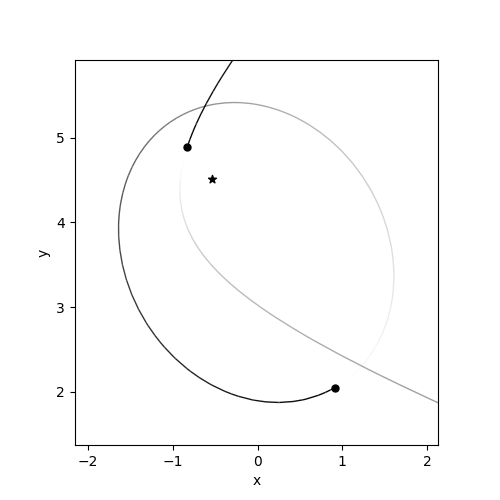

.
----------------------------------------------------------------------
Ran 1 test in 0.061s

OK


In [12]:
if IN_JUPYTER:
    def test_integrate(self):
        
        Verbose.VERBOSITY=VERB_NONE
        
        nspangles=100
        sys=System(resetable=False)
        S=sys.add(bhash="Star",nspangles=nspangles,m=8,radius=1,x=0,vy=2)
        P=sys.add("Planet",primary=S,bhash="Planet",nspangles=nspangles,radius=0.2,a=2)
        M=sys.add("Planet",primary=P,bhash="Moon",nspangles=nspangles,radius=0.1,a=1,M=120*Consts.deg)
        R=sys.add("Ring",primary=P,bhash="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=90*Consts.deg)
        sys.sim.integrate(1)
        rb.OrbitPlot(sys.sim)
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_integrate=test_integrate
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

## Spangle System

In [13]:
def spangle_system(self):
    """Generate the spangles of the objects in the system
    
    Attributes created:
        
        spanglers: dictionary of Spangler objects:
            Spangler corresponding to each object in the system.
            
        sp: Spangler:
            Spangler corresponding to all system.
            
    Result:
        
        This method create the spangler of the system

    """
    
    self._spanglers=dict()
    source=1
    for bhash,body in self.bodies.items():
        
        verbose(VERB_SIMPLE,f"Spangling body '{bhash}' (kind '{body.kind}')")
        body.spangle_body()

        if body.kind=="Star":
            body.sg.data.source=source
            source+=1
        
        #Center object around its position according to rebound
        body.sg.set_positions(center_ecl=self.sim.particles[body.rbhash].xyz)
            
        self._spanglers[bhash]=body.sg
    
    #Join spanglers
    self.sg=Spangler(spanglers=list(self._spanglers.values()))
    
    #Add column for controlling information on sources
    for source in range(1,self.nsources+1):
        for source_state in SPANGLER_SOURCE_STATES.keys():
            self.sg.data[source_state+f"_{source}"]=0
    
    #Save state of the system
    if self._resetable:
        self.save_to(self._snap_file_name)
    
    #Already spangled
    self._spangled=True

System.spangle_system=spangle_system

2
{'Star2': <pryngles.body.Star object at 0x7fe0289f2ca0>, 'Star1': <pryngles.body.Star object at 0x7fe0289f2c70>}
Index(['sphash', 'spangle_type', 'geometry', 'scale', 'n_equ', 'alpha_equ',
       'w', 'q0', 'center_equ', 'x_equ', 'y_equ', 'z_equ', 'r_equ', 'q_equ',
       'f_equ', 'ns_equ', 'center_ecl', 'x_ecl', 'y_ecl', 'z_ecl', 'ns_ecl',
       'center_int', 'x_int', 'y_int', 'z_int', 'ns_int', 'rho_int', 'az_int',
       'cost_int', 'cos_int', 'd_int', 'z_cen_int', 'center_obs', 'x_obs',
       'y_obs', 'z_obs', 'ns_obs', 'rho_obs', 'az_obs', 'cost_obs', 'cos_obs',
       'd_obs', 'z_cen_obs', 'center_luz', 'x_luz', 'y_luz', 'z_luz', 'ns_luz',
       'rho_luz', 'az_luz', 'cost_luz', 'cos_luz', 'd_luz', 'z_cen_luz', 'asp',
       'dsp', 'albedo_gray_normal', 'tau_gray_optical', 'unset', 'hidden',
       'source', 'visible', 'intersect', 'shadow', 'indirect', 'emit', 'above',
       'illuminated', 'transmit', 'transit', 'occult', 'illuminated_1',
       'transmit_1', 'transit_1', '

<IPython.core.display.Javascript object>


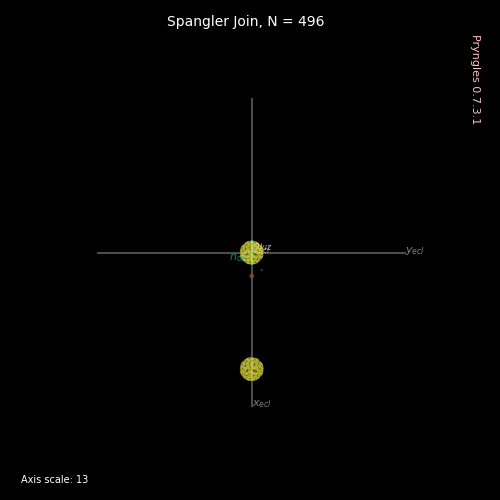

.
----------------------------------------------------------------------
Ran 1 test in 0.559s

OK


In [14]:
if IN_JUPYTER:
    def test_spangle(self):
        
        Verbose.VERBOSITY=VERB_NONE
        
        nspangles=100
        sys=System(resetable=False)
        S2=sys.add(bhash="Star2",nspangles=nspangles,m=8,radius=1,x=10,vy=-2)
        S1=sys.add(bhash="Star1",nspangles=nspangles,m=9,radius=1,x=0,vy=+2)
        P=sys.add("Planet",primary=S1,bhash="Planet",nspangles=nspangles,radius=0.2,a=2)
        M=sys.add("Planet",primary=P,bhash="Moon",nspangles=nspangles,radius=0.1,a=1,M=120*Consts.deg)
        R=sys.add("Ring",primary=P,bhash="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=90*Consts.deg)
        
        sys.spangle_system()
        
        #Check addition columns
        print(sys.nsources)
        print(sys.sources)
        print(sys.sg.data.columns)
        
        #Check save
        sys.save_to("/tmp/system.pkl")
        
        #Check plot
        #sys.sp.plot3d(center_at="Ring",not_plot=["Star1","Star2"])
        sys.sg.plot3d()

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_spangle=test_spangle
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

### Miscelaneous methods

In [15]:
def update_body(self,body,**props):
    """Update properties of a body in the system
    
    Parameters:
        body: string or Body:
            Body to update
        
        props: dict:
            Dictionary with properties of the object
    """
    #Update spangling?
    if self._is_spangled():
        raise AssertionError("After spangling you cannot update the properties of the bodies.  Please rebuild the system")

    #Update body properties
    if isinstance(body,Body):
        body.update_body(**props)
    elif body in self.bodies:
        body=self.bodies[body]
        lkind=body.kind.lower()
        exec(f"body.update_{lkind}()")
    else:
        raise AssertionError("You are trying to update a body ({body}) which is not in the system")
        
    #Check if among props there is any property related to position
    if any(k in props for k in REBOUND_ORBITAL_PROPERTIES):
        raise ValueError(f"You cannot update an orbital property {props} without compromising the full simulation. Rebuild the system from scratch.")
        
System.update_body=update_body

In [16]:
if IN_JUPYTER:
    def test_update(self):
        
        Verbose.VERBOSITY=VERB_NONE
        
        nspangles=100
        sys=System(resetable=True)
        S=sys.add(hash="Star",nspangles=nspangles,m=8,radius=1,x=0,vy=2)
        P=sys.add("Planet",primary=S,bhash="Planet",nspangles=nspangles,radius=0.2,a=2)
        M=sys.add("Planet",primary=P,bhash="Moon",nspangles=nspangles,radius=0.1,a=1,M=120*Consts.deg)
        R=sys.add("Ring",primary=P,bhash="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=90*Consts.deg)
        print(P.radius)
        sys.update_body(P,radius=0.5)
        print(P.radius)
        sys.update_body("Ring",fe=3.0)
        print(R.radius)
        sys.spangle_system()
        self.assertRaises(AssertionError,lambda:sys.update_body("Ring",fe=3.0))

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_update=test_update
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

Property hash not identified in object Star
0.2
0.5
1.15


.
----------------------------------------------------------------------
Ran 1 test in 0.212s

OK


In [17]:
def set_observer(self,nvec=[0,0,1],alpha=0,center=None):
    """Set the position of the observer
    """
    #Only set observer if it is spangled
    self.n_obs=nvec
    self.alpha_obs=alpha
    self.center=center
    if self._is_spangled():
        #Set observer
        self.sg.set_observer(nvec=self.n_obs,alpha=self.alpha_obs,center=self.center)
    else:
        raise AssertionError("You must first spangle system before setting observer direction.")
        
System.set_observer=set_observer

<IPython.core.display.Javascript object>


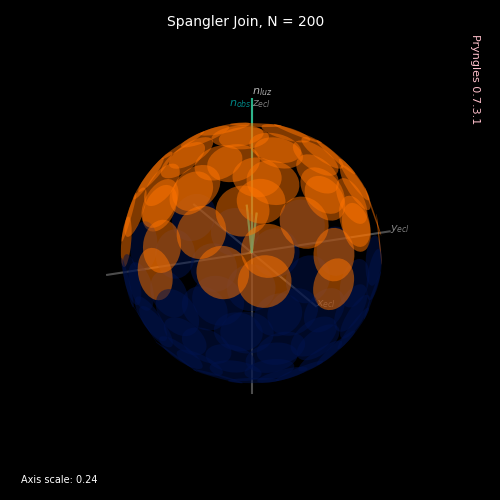

<IPython.core.display.Javascript object>


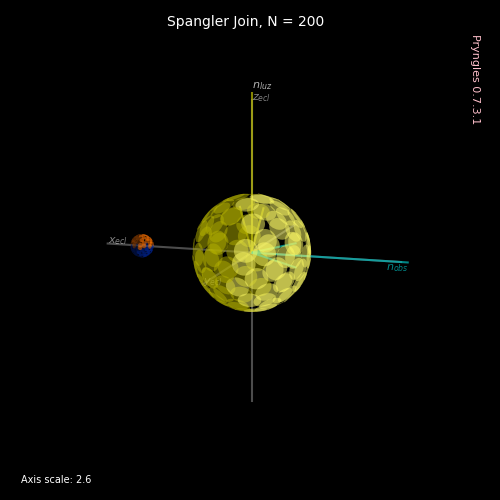

<IPython.core.display.Javascript object>


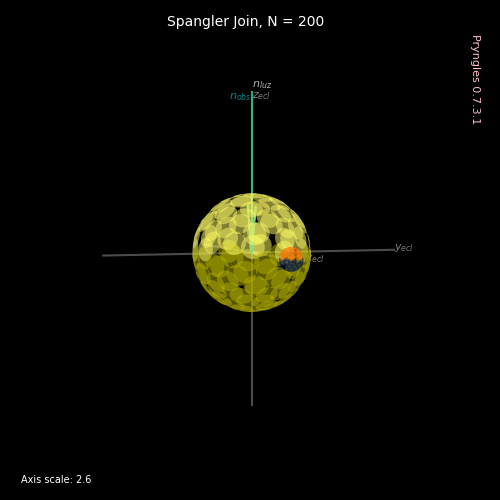

.
----------------------------------------------------------------------
Ran 1 test in 0.487s

OK


In [18]:
if IN_JUPYTER:
    def test_obs(self):
        
        global sys
        
        Verbose.VERBOSITY=VERB_NONE
        
        nspangles=100
        
        #Define system
        sys=System(resetable=True)
        
        #Add objects
        S=sys.add(bhash="Star",nspangles=nspangles,m=8,radius=1,x=0,vy=2)
        P=sys.add("Planet",primary=S,bhash="Planet",nspangles=nspangles,radius=0.2,a=2)
        
        #Test setting observer without spangling
        self.assertRaises(AssertionError,lambda:sys.set_observer(nvec=[1,0,0]))
        
        #Spangle system
        sys.spangle_system()
        
        sys.sg.plot3d(center_at="Planet",not_plot=["Star"])
        
        sys.set_observer(nvec=[-1,0,0])
        sys.sg.plot3d()
        
        sys.set_observer(nvec=[0,0,1])
        sys.sg.plot3d()
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_obs=test_obs
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [19]:
def reset(self):
    """Reset system to spangling state
    """
    if self._resetable:
        self.load_from(self._snap_file_name)
        pass
    else:
        print("System is not resetable. Use resetable = True when defining the System or when you spangle it.")
    
System.reset=reset

<IPython.core.display.Javascript object>


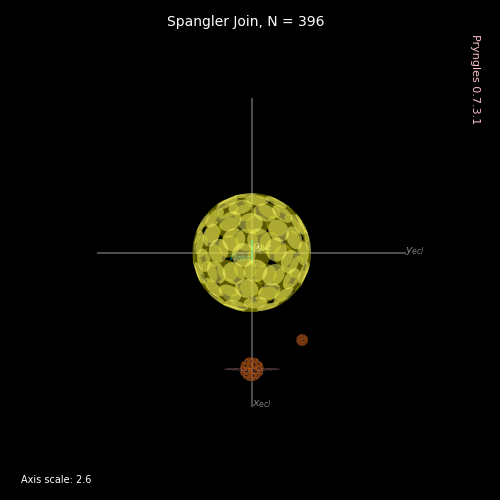

<IPython.core.display.Javascript object>


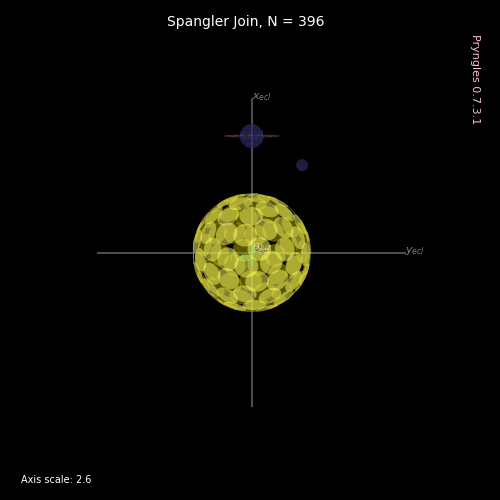

<IPython.core.display.Javascript object>


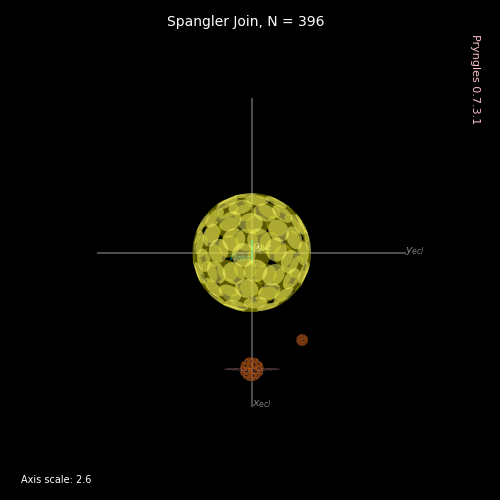

.
----------------------------------------------------------------------
Ran 1 test in 0.915s

OK


In [22]:
if IN_JUPYTER:
    def test_reset(self):
        
        Verbose.VERBOSITY=VERB_NONE
        
        nspangles=100
        sys=System(resetable=True)
        S=sys.add(bhash="Star",nspangles=nspangles,m=8,radius=1,x=0,vy=2)
        P=sys.add("Planet",primary=S,bhash="Planet",nspangles=nspangles,radius=0.2,a=2)
        M=sys.add("Planet",primary=P,bhash="Moon",nspangles=nspangles,radius=0.1,a=1,M=120*Consts.deg)
        R=sys.add("Ring",primary=P,bhash="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=90*Consts.deg)
        sys.spangle_system()

        #All transformations from here are not stored
        sys.sg.plot3d()
        sys.set_observer(nvec=[0,0,-1])
        sys.sg.plot3d()

        #All transformations from here are not stored
        sys.reset()
        sys.sg.plot3d()

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_reset=test_reset
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

## Illumination

In [22]:
def update_illumination(self):
    """Determine the visibility conditions of the spangles
    
    Update n_luz differently according to body hash
    """
    #Calculate the hull of the bodies in the system
    for body in self.bodies.values():
        #Body information
        bhash=body.hash
        bkind=body.kind
    
System.update_illumination=update_illumination

--End--

In [47]:
nspangles=1000
sys=System(resetable=False)
#S2=sys.add(bhash="Star2",nspangles=nspangles,m=8,radius=1,x=0,vy=2)
S1=sys.add(bhash="Star1",nspangles=nspangles,m=9,radius=1,x=10,vy=-2)
P=sys.add("Planet",primary=S1,bhash="Planet",nspangles=nspangles,radius=0.2,a=2)
M=sys.add("Planet",primary=P,bhash="Moon",
          nspangles=nspangles,spangle_type=SPANGLE_LIQUID,
          radius=0.1,a=1,M=120*Consts.deg)
R=sys.add("Ring",primary=P,bhash="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=80*Consts.deg)
sys.spangle_system()

<IPython.core.display.Javascript object>


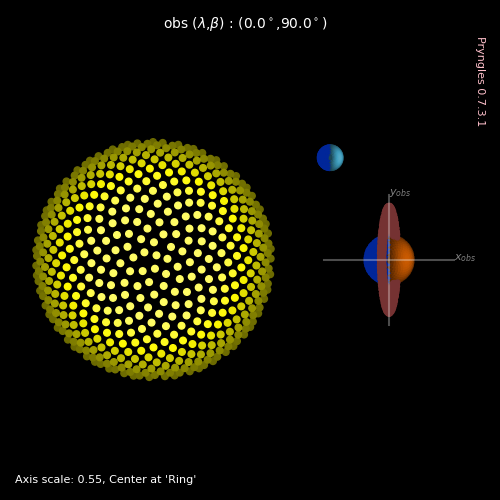

In [48]:
sys.sg.reset_state()
sys.sg.set_luz(nvec=[1,0,0])
sys.sg.update_illumination_state()

sys.sg.set_observer(nvec=[0,0,1])
sys.sg.update_visibility_state()

sys.sg.plot2d(center_at="Ring")

## Illumination according to direction

In [28]:
sys=System(resetable=True)
nspangles=1000
S=sys.add(bhash="Star",nspangles=nspangles,m=8,radius=1,x=0,vy=2)
nspangles=200
P=sys.add("Planet",primary=S,bhash="Planet",nspangles=nspangles,radius=0.2,a=2)
M=sys.add("Planet",primary=P,bhash="Moon",nspangles=nspangles,radius=0.1,a=1,M=90*Consts.deg)
M.update_body(spangle_type=SPANGLE_LIQUID)
R=sys.add("Ring",primary=P,bhash="Ring",nspangles=nspangles,fi=2.0,fe=3.0,i=20*Consts.deg)
sys.spangle_system()

In [29]:
sys.sg.save_to("tmp/star-planet-ring.pkl")

<IPython.core.display.Javascript object>


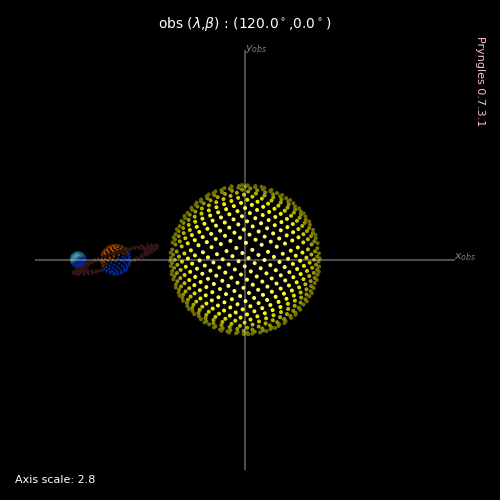

In [41]:
sys.sg.reset_state()

sys.sg.set_observer(nvec=sci.direction([120,0]))
sys.sg.update_visibility_state()

sys.sg.set_luz(nvec=sci.direction([30,60]))
sys.sg.update_illumination_state()

sys.sg.plot2d()

<IPython.core.display.Javascript object>


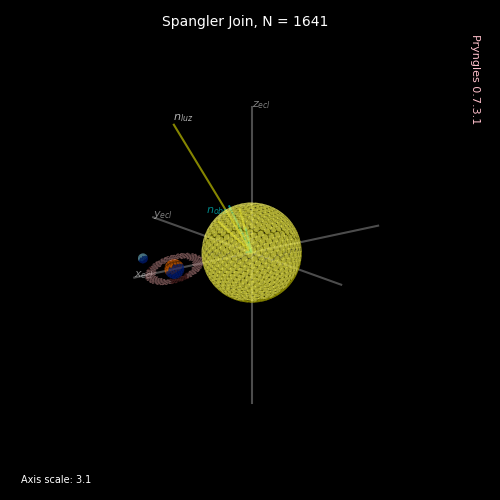

In [42]:
sys.sg.plot3d()

### Final

Checking body Star (Star)
zmin = -0.9987894956873206, zmed = -4.802535567821457e-06, zmax = 0.9988462422186081
Points above: 331
Points below: 0
Checking body Planet (Planet)
zmin = 1.8012845568290787, zmed = 2.0000096379768437, zmax = 2.198955238475072
Points above: 13
Points below: 25
Checking body Ring (Ring)
zmin = 1.4366474002995593, zmed = 2.0006853273700784, zmax = 2.563815391278934
	Splitting ring in two parts
Up: 165
Down: 166
Points below middle up of ring: 25
Points below middle down of ring: 7


<IPython.core.display.Javascript object>


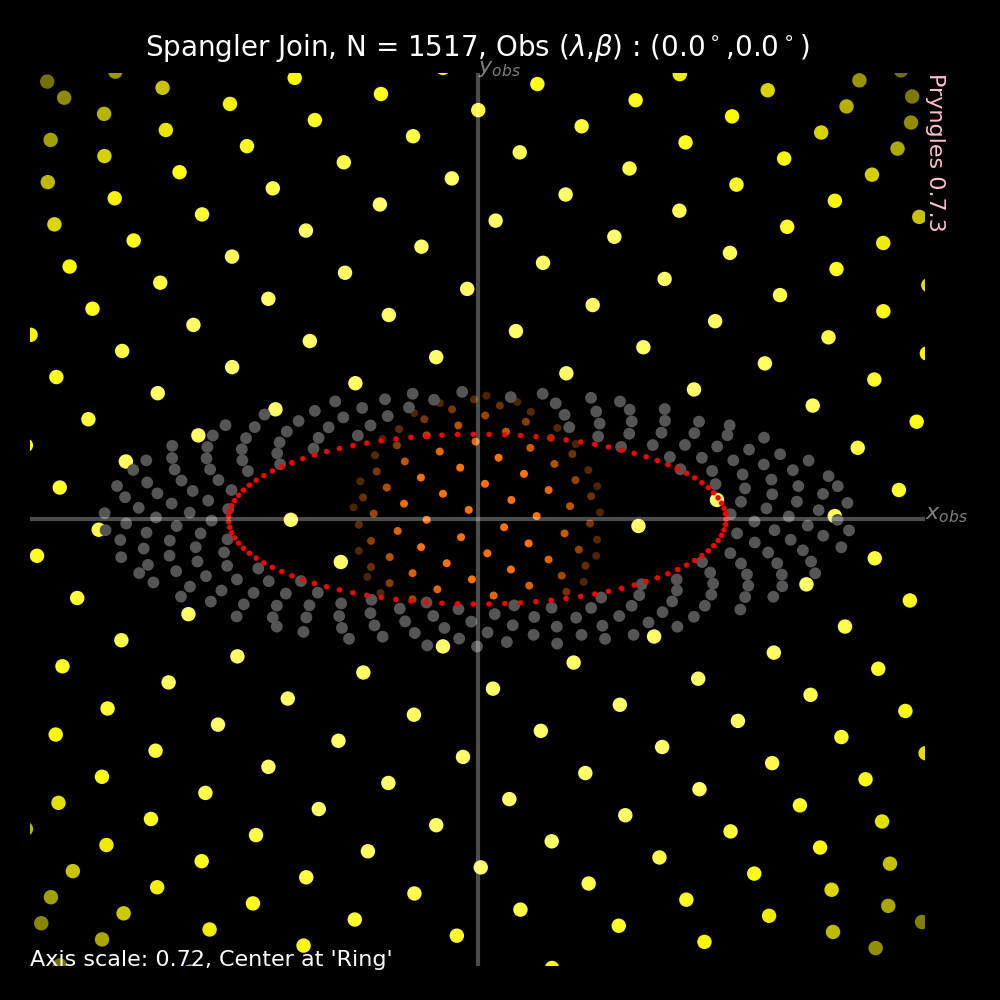

<IPython.core.display.Javascript object>


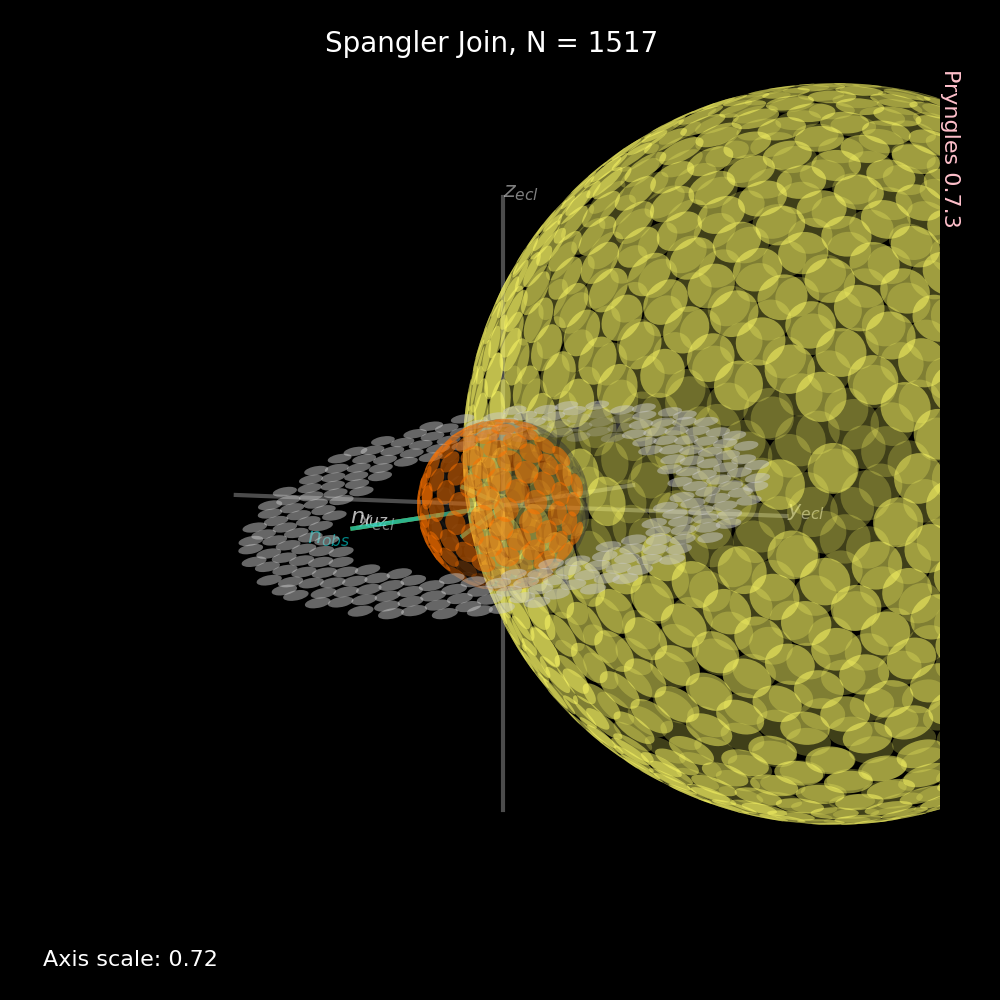

In [76]:
sys=System()
nspangles=1000
S=sys.add(hash="Star",nspangles=nspangles,m=8,radius=1,x=0,vy=2)
nspangles=200
P=sys.add("Planet",primary=S,hash="Planet",nspangles=nspangles,radius=0.2,a=2)
#M=sys.add("Planet",primary=P,hash="Moon",nspangles=nspangles,radius=0.1,a=1,M=90*Consts.deg)
R=sys.add("Ring",primary=P,hash="Ring",nspangles=nspangles,fi=2.0,fe=3.0,i=20*Consts.deg)
sys.spangle_system()
sys.sp.set_luz(nvec=[1,0,0])
sys.set_observer(nvec=[1,0,0])
sys.update_system_visibility()
sys.sp.plot_obs(center_at="Ring")
sys.sp.plot3d(center_at="Ring")

In [ ]:
def calc_intersect(self):
    """Determine the visibility conditions of the spangles
    """
    #Set invisible the hidden spangles
    cond=(self.sp.data.hidden)
    self.sp.data.loc[cond,"visible"]=False
    
    cond=(self.sp.data.type==STAR_SPANGLE)
    self.sp.data.loc[cond,"illuminated"]=True
    
    #Calculate the hull of the bodies in the system
    for body in self.bodies.values():

        #Body information
        bhash=body.hash
        bkind=body.kind
        print(f"Checking body {bhash} ({bkind})")
        
        #All points in body
        cond=(self.sp.data.body_hash==bhash)

        #Range of coordinates
        body.zmin=self.sp.data[cond]["z_obs"].min()
        body.zmed=self.sp.data[cond]["z_obs"].mean()
        body.zmax=self.sp.data[cond]["z_obs"].max()
        print(f"zmin = {body.zmin}, zmed = {body.zmed}, zmax = {body.zmax}")

        if bkind=="Ring":
            #Split ring in two parts
            print("\tSplitting ring in two parts")
            cond_up=(self.sp.data[cond]["z_obs"]>=body.zmed)
            
            data_up=self.sp.data[cond&cond_up][["x_obs","y_obs"]]
            data_down=self.sp.data[cond&(~cond_up)][["x_obs","y_obs"]]
            data_hole=self.sp.data[cond&(self.sp.data[cond].hidden)][["x_obs","y_obs"]]
            
            print("Up:",len(data_up))
            print("Down:",len(data_down))
            
            body.qhull_up=ConvexHull(data_up)
            body.qhull_down=ConvexHull(data_down)
            body.qhull_hole=ConvexHull(data_hole)
            
            #Check position of all points
            inhull_up=sci.points_in_hull(self.sp.data[["x_obs","y_obs"]],body.qhull_up)
            inhull_down=sci.points_in_hull(self.sp.data[["x_obs","y_obs"]],body.qhull_down)
            inhull_hole=sci.points_in_hull(self.sp.data[["x_obs","y_obs"]],body.qhull_hole)
            
            #Points below halfs of the ring
            cond=(~self.sp.data.hidden)&(self.sp.data.body_hash!=bhash)&(self.sp.data.visible)
             
            below=(inhull_up)&(~inhull_hole)&(self.sp.data[cond]["z_obs"]<=body.zmax)
            print(f"Points below middle up of ring: {sum(below)}")
            self.sp.data.loc[below,"visible"]=False

            below=(inhull_down)&(~inhull_hole)&(self.sp.data[cond]["z_obs"]<=body.zmed)
            print(f"Points below middle down of ring: {sum(below)}")
            self.sp.data.loc[below,"visible"]=False
            
        else:
            #Build convex hull
            body.qhull=ConvexHull(self.sp.data[cond][["x_obs","y_obs"]])

            #Check position of all points
            inhull=sci.points_in_hull(self.sp.data[["x_obs","y_obs"]],body.qhull)

            #Points above and below
            cond=(~self.sp.data.hidden)&(self.sp.data.body_hash!=bhash)&(self.sp.data.visible)
            above=(inhull)&(self.sp.data[cond]["z_obs"]>body.zmax)
            print(f"Points above: {sum(above)}")
            below=(inhull)&(self.sp.data[cond]["z_obs"]<body.zmin)
            print(f"Points below: {sum(below)}")
        
            if bkind=="Star":
                #In the case of sources
                self.sp.data.loc[above,"transit"]=True
                self.sp.data.loc[below,"occult"]=True

            #Objects below
            self.sp.data.loc[below,"visible"]=False

System.update_system_visibility=update_system_visbility

In [73]:
def update_system_visbility(self):
    """Determine the visibility conditions of the spangles
    """
    #Set invisible the hidden spangles
    cond=(self.sp.data.hidden)
    self.sp.data.loc[cond,"visible"]=False
    
    cond=(self.sp.data.type==STAR_SPANGLE)
    self.sp.data.loc[cond,"illuminated"]=True
    
    #Calculate the hull of the bodies in the system
    for body in self.bodies.values():

        #Body information
        bhash=body.hash
        bkind=body.kind
        print(f"Checking body {bhash} ({bkind})")
        
        #All points in body
        cond=(self.sp.data.body_hash==bhash)

        #Range of coordinates
        body.zmin=self.sp.data[cond]["z_obs"].min()
        body.zmed=self.sp.data[cond]["z_obs"].mean()
        body.zmax=self.sp.data[cond]["z_obs"].max()
        print(f"zmin = {body.zmin}, zmed = {body.zmed}, zmax = {body.zmax}")

        if bkind=="Ring":
            #Split ring in two parts
            print("\tSplitting ring in two parts")
            cond_up=(self.sp.data[cond]["z_obs"]>=body.zmed)
            
            data_up=self.sp.data[cond&cond_up][["x_obs","y_obs"]]
            data_down=self.sp.data[cond&(~cond_up)][["x_obs","y_obs"]]
            data_hole=self.sp.data[cond&(self.sp.data[cond].hidden)][["x_obs","y_obs"]]
            
            print("Up:",len(data_up))
            print("Down:",len(data_down))
            
            body.qhull_up=ConvexHull(data_up)
            body.qhull_down=ConvexHull(data_down)
            body.qhull_hole=ConvexHull(data_hole)
            
            #Check position of all points
            inhull_up=sci.points_in_hull(self.sp.data[["x_obs","y_obs"]],body.qhull_up)
            inhull_down=sci.points_in_hull(self.sp.data[["x_obs","y_obs"]],body.qhull_down)
            inhull_hole=sci.points_in_hull(self.sp.data[["x_obs","y_obs"]],body.qhull_hole)
            
            #Points below halfs of the ring
            cond=(~self.sp.data.hidden)&(self.sp.data.body_hash!=bhash)&(self.sp.data.visible)
             
            below=(inhull_up)&(~inhull_hole)&(self.sp.data[cond]["z_obs"]<=body.zmax)
            print(f"Points below middle up of ring: {sum(below)}")
            self.sp.data.loc[below,"visible"]=False

            below=(inhull_down)&(~inhull_hole)&(self.sp.data[cond]["z_obs"]<=body.zmed)
            print(f"Points below middle down of ring: {sum(below)}")
            self.sp.data.loc[below,"visible"]=False
            
        else:
            #Build convex hull
            body.qhull=ConvexHull(self.sp.data[cond][["x_obs","y_obs"]])

            #Check position of all points
            inhull=sci.points_in_hull(self.sp.data[["x_obs","y_obs"]],body.qhull)

            #Points above and below
            cond=(~self.sp.data.hidden)&(self.sp.data.body_hash!=bhash)&(self.sp.data.visible)
            above=(inhull)&(self.sp.data[cond]["z_obs"]>body.zmax)
            print(f"Points above: {sum(above)}")
            below=(inhull)&(self.sp.data[cond]["z_obs"]<body.zmin)
            print(f"Points below: {sum(below)}")
        
            if bkind=="Star":
                #In the case of sources
                self.sp.data.loc[above,"transit"]=True
                self.sp.data.loc[below,"occult"]=True

            #Objects below
            self.sp.data.loc[below,"visible"]=False

System.update_system_visibility=update_system_visbility

In [61]:
def update_system_visbility(self):
    """Determine the visibility conditions of the spangles
    """
    #Prepare
    self.sp.data.illuminated=False
    
    #Set invisible the hidden spangles
    cond=(self.sp.data.hidden)
    self.sp.data.loc[cond,"visible"]=False
    
    #Calculate the hull of the bodies in the system
    for body in self.bodies.values():

        #Body information
        bhash=body.hash
        bkind=body.kind
        print(f"Checking body {bhash} ({bkind})")
        
        #All points in body
        cond=(self.sp.data.body_hash==bhash)

        #Range of coordinates
        body.zmin=self.sp.data[cond]["z_obs"].min()
        body.zmed=self.sp.data[cond]["z_obs"].mean()
        body.zmax=self.sp.data[cond]["z_obs"].max()
        print(f"zmin = {body.zmin}, zmed = {body.zmed}, zmax = {body.zmax}")

        if bkind=="Ring":
            #Split ring in two parts
            print("\tSplitting ring in two parts")
            cond_up=(self.sp.data[cond]["z_obs"]>=body.zmed)
            
            data_up=self.sp.data[cond&cond_up][["x_obs","y_obs"]]
            data_down=self.sp.data[cond&(~cond_up)][["x_obs","y_obs"]]
            data_hole=self.sp.data[cond&(self.sp.data[cond].hidden)][["x_obs","y_obs"]]
            
            print("Up:",len(data_up))
            print("Down:",len(data_down))
            
            body.qhull_up=ConvexHull(data_up)
            body.qhull_down=ConvexHull(data_down)
            body.qhull_hole=ConvexHull(data_hole)
            
            #Check position of all points
            inhull_up=sci.points_in_hull(self.sp.data[["x_obs","y_obs"]],body.qhull_up)
            inhull_down=sci.points_in_hull(self.sp.data[["x_obs","y_obs"]],body.qhull_down)
            inhull_hole=sci.points_in_hull(self.sp.data[["x_obs","y_obs"]],body.qhull_hole)
            
            #Points below halfs of the ring
            cond=(~self.sp.data.hidden)&(self.sp.data.body_hash!=bhash)&(self.sp.data.visible)
             
            below=(inhull_up)&(~inhull_hole)&(self.sp.data[cond]["z_obs"]<=body.zmax)
            print(f"Points below middle up of ring: {sum(below)}")
            self.sp.data.loc[below,"visible"]=False

            below=(inhull_down)&(~inhull_hole)&(self.sp.data[cond]["z_obs"]<=body.zmed)
            print(f"Points below middle down of ring: {sum(below)}")
            self.sp.data.loc[below,"visible"]=False
            
        else:
            #Build convex hull
            body.qhull=ConvexHull(self.sp.data[cond][["x_obs","y_obs"]])

            #Check position of all points
            inhull=sci.points_in_hull(self.sp.data[["x_obs","y_obs"]],body.qhull)

            #Points above and below
            cond=(~self.sp.data.hidden)&(self.sp.data.body_hash!=bhash)&(self.sp.data.visible)
            above=(inhull)&(self.sp.data[cond]["z_obs"]>body.zmax)
            print(f"Points above: {sum(above)}")
            below=(inhull)&(self.sp.data[cond]["z_obs"]<body.zmin)
            print(f"Points below: {sum(below)}")
        
            if bkind=="Star":
                #In the case of sources
                self.sp.data.loc[above,"transit"]=True
                self.sp.data.loc[below,"occult"]=True

            #Objects below
            self.sp.data.loc[below,"visible"]=False

System.update_system_visibility=update_system_visbility

### Improved

In [ ]:
def update_system_visbility(self):
    """Determine the visibility conditions of the spangles
    """
    #Prepare
    self.sp.data.illuminated=False
    
    #Set invisible the hidden spangles
    cond=(self.sp.data.hidden)
    self.sp.data.loc[cond,"visible"]=False
    
    #Calculate the hull of the bodies in the system
    for body in self.bodies.values():

        #Body information
        bhash=body.hash
        bkind=body.kind
        print(f"Checking body {bhash} ({bkind})")
        
        #All points in body
        cond=(self.sp.data.body_hash==bhash)

        #Range of coordinates
        body.zmin=self.sp.data[cond]["z_obs"].min()
        body.zmed=self.sp.data[cond]["z_obs"].mean()
        body.zmax=self.sp.data[cond]["z_obs"].max()
        print(f"zmin = {body.zmin}, zmed = {body.zmed}, zmax = {body.zmax}")

        if bkind=="Ring":
            #Split ring in two parts
            print("\tSplitting ring in two parts")
            cond_up=(self.sp.data[cond]["z_obs"]>=body.zmed)
            
            data_up=self.sp.data[cond&cond_up][["x_obs","y_obs"]]
            data_down=self.sp.data[cond&(~cond_up)][["x_obs","y_obs"]]
            data_hole=self.sp.data[cond&(self.sp.data[cond].hidden)][["x_obs","y_obs"]]
            
            print("Up:",len(data_up))
            print("Down:",len(data_down))
            
            body.qhull_up=ConvexHull(data_up)
            body.qhull_down=ConvexHull(data_down)
            body.qhull_hole=ConvexHull(data_hole)
            
            #Check position of all points
            inhull_up=sci.points_in_hull(self.sp.data[["x_obs","y_obs"]],body.qhull_up)
            inhull_down=sci.points_in_hull(self.sp.data[["x_obs","y_obs"]],body.qhull_down)
            inhull_hole=sci.points_in_hull(self.sp.data[["x_obs","y_obs"]],body.qhull_hole)
            
            #Points below halfs of the ring
            cond=(~self.sp.data.hidden)&(self.sp.data.body_hash!=bhash)&(self.sp.data.visible)
             
            below=(inhull_up)&(~inhull_hole)&(self.sp.data[cond]["z_obs"]<=body.zmax)
            print(f"Points below middle up of ring: {sum(below)}")
            self.sp.data.loc[below,"visible"]=False

            below=(inhull_down)&(~inhull_hole)&(self.sp.data[cond]["z_obs"]<=body.zmed)
            print(f"Points below middle down of ring: {sum(below)}")
            self.sp.data.loc[below,"visible"]=False
            
        else:
            #Build convex hull
            body.qhull=ConvexHull(self.sp.data[cond][["x_obs","y_obs"]])

            #Check position of all points
            inhull=sci.points_in_hull(self.sp.data[["x_obs","y_obs"]],body.qhull)

            #Points above and below
            cond=(~self.sp.data.hidden)&(self.sp.data.body_hash!=bhash)&(self.sp.data.visible)
            above=(inhull)&(self.sp.data[cond]["z_obs"]>body.zmax)
            print(f"Points above: {sum(above)}")
            below=(inhull)&(self.sp.data[cond]["z_obs"]<body.zmin)
            print(f"Points below: {sum(below)}")
        
            if bkind=="Star":
                #In the case of sources
                self.sp.data.loc[above,"transit"]=True
                self.sp.data.loc[below,"occult"]=True

            #Objects below
            self.sp.data.loc[below,"visible"]=False

System.update_system_visibility=update_system_visbility

### Original

In [37]:
def update_system_visbility(self):
    """Determine the visibility conditions of the spangles
    """
    #Prepare
    self.sp.data.illuminated=False
    ºa
    #Set invisible the hidden spangles
    cond=(self.sp.data.hidden)
    self.sp.data.loc[cond,"visible"]=False
    
    #Calculate the hull of the bodies in the system
    for body in self.bodies.values():

        #Body information
        bhash=body.hash
        bkind=body.kind
        print(f"Checking body {bhash} ({bkind})")
        
        #Build convex hull
        cond=(self.sp.data.body_hash==bhash)
        body.qhull=ConvexHull(self.sp.data[cond][["x_obs","y_obs"]])
        
        #Range of coordinates
        body.zmin=self.sp.data[cond]["z_obs"].min()
        body.zmax=self.sp.data[cond]["z_obs"].max()
        print(f"Range of body:",body.zmin,body.zmax)

        #Check position of all points
        inhull=sci.points_in_hull(self.sp.data[["x_obs","y_obs"]],body.qhull)
        
        #Points above and below
        cond=(~self.sp.data.hidden)&(self.sp.data.body_hash!=bhash)&(self.sp.data.visible)
        above=(inhull)&(self.sp.data[cond]["z_obs"]>body.zmax)
        print(f"Points above: {sum(above)}")
        below=(inhull)&(self.sp.data[cond]["z_obs"]<body.zmin)
        print(f"Points below: {sum(below)}")
        
        if bkind=="Star":
            #In the case of sources
            self.sp.data.loc[above,"transit"]=True
            self.sp.data.loc[below,"occult"]=True

        #Objects below
        self.sp.data.loc[below,"visible"]=False

System.update_system_visibility=update_system_visbility

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Checking body Star (Star)
zmin = -0.9994972743972943, zmed = 7.383661997741752e-06, zmax = 0.9981096594436805
Points above: 0
Points below: 546
Checking body Planet (Planet)
zmin = -1.914885306304547, zmed = -1.714984374692686, zmax = -1.515363919536352
Points above: 95
Points below: 0
Checking body Moon (Planet)
zmin = -2.6724285045773617, zmed = -2.5724780387714343, zmax = -2.4726678111932636
Points above: 0
Points below: 0
Checking body Ring (Ring)
zmin = -2.116961018564543, zmed = -1.7150502667720822, zmax = -1.3128186228612055
	Splitting ring in two parts
Up: 566
Down: 567
Points below middle up of ring: 110
Points below middle down of ring: 0


<IPython.core.display.Javascript object>


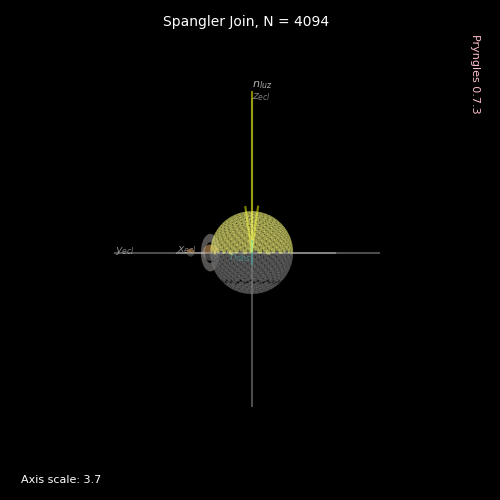

/Users/jorgezuluagacallejas/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:70: ResourceWarning: unclosed file <_io.BufferedWriter name='/tmp/system.pkl'>
  passkwargs = {k: v for k, v in kwargs.items()


<IPython.core.display.Javascript object>


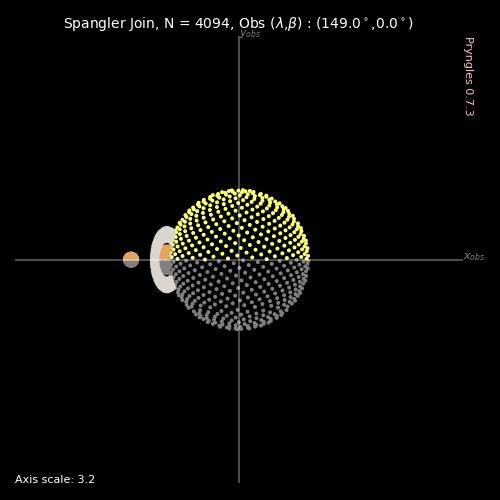

.
----------------------------------------------------------------------
Ran 1 test in 4.530s

OK


In [190]:
if IN_JUPYTER:
    def test_visibility(self):
        
        Verbose.VERBOSITY=VERB_NONE
        
        nspangles=1000
        sys=System()
        S=sys.add(hash="Star",nspangles=nspangles,m=8,radius=1,x=0,vy=2)
        P=sys.add("Planet",primary=S,hash="Planet",nspangles=nspangles,radius=0.2,a=2)
        M=sys.add("Planet",primary=P,hash="Moon",nspangles=nspangles,radius=0.1,a=1,M=0*Consts.deg)
        R=sys.add("Ring",primary=P,hash="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=90*Consts.deg,roll=30*Const.deg)
        sys.spangle_system()
        sys.set_observer(n_obs=[-1,0.6,0])
        sys.update_system_visibility()
        sys.sp.set_luz(n_luz=[0,0,1])
        sys.sp.plot3d()
        sys.sp.plot_obs(show_hidden=False)

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_visibility=test_visibility
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [37]:
nspangles=500
sys=System()
S=sys.add("Star",hash="Star",nspangles=nspangles,m=1,radius=0.1)
nspangles=500
P=sys.add("Planet",primary=S,hash="Planet",nspangles=nspangles,m=0.1,radius=0.02,a=1)
R=sys.add("Ring",primary=P,hash="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=20*Consts.deg,roll=90*Const.deg)
sys.spangle_system()

In [46]:
sys.set_observer(nvec=[0,1,0])
sys.update_system_visibility()
sys.sp.set_luz(nvec=[1,0,0])
#sys.sp.plot3d(center_at="Ring")
#sys.sp.plot3d(center_at="Ring")
sys.sp.plot_obs(center_at="Star",show_hidden=False)
sys.sp.plot3d(center_at="Planet",show_hidden=False)

Checking body Star (Star)
zmin = -0.9997353043593837, zmed = 6.347033359171687e-06, zmax = 0.9990620212050354
Points above: 0
Points below: 0
Checking body Planet (Planet)
zmin = -0.19994706087187675, zmed = 1.2694066718341195e-06, zmax = 0.1998124042410071
Points above: 191
Points below: 191
Checking body Moon (Planet)
zmin = 0.7660518733485007, zmed = 0.8660260384877748, zmax = 0.9659316059049425
Points above: 0
Points below: 0
Checking body Ring (Ring)
zmin = -0.4597612443087352, zmed = -7.367539715638504e-05, zmax = 0.4599809155886971
	Splitting ring in two parts
Up: 566
Down: 567


QhullError: QH6013 qhull input error: input is less than 2-dimensional since all points have the same x coordinate   -2

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 438834283  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 0.92  Error-roundoff 1.5e-15  _one-merge 7.7e-15
  _near-inside 3.9e-14  Visible-distance 3.1e-15  U-max-coplanar 3.1e-15
  Width-outside 6.2e-15  _wide-facet 1.9e-14  _maxoutside 9.3e-15


In [181]:
nspangles=1000
sys=System()
S=sys.add(hash="Star",nspangles=nspangles,m=8,radius=1,x=0,vy=2)
P=sys.add("Planet",primary=S,hash="Planet",nspangles=nspangles,radius=0.2,a=2)
M=sys.add("Planet",primary=P,hash="Moon",nspangles=nspangles,radius=0.1,a=1,M=0*Consts.deg)
R=sys.add("Ring",primary=P,hash="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=90*Consts.deg,roll=30*Const.deg)
sys.spangle_system()
#sys.set_observer(n_obs=[-1,-0.5,0])
#sys.set_observer(n_obs=[1,0.3,0])
#sys.set_observer(n_obs=[1,0,0])

Checking body Star (Star)
zmin = -0.9994972743972943, zmed = 7.383661997741752e-06, zmax = 0.9981096594436805
Points above: 0
Points below: 546
Checking body Planet (Planet)
zmin = -1.914885306304547, zmed = -1.714984374692686, zmax = -1.515363919536352
Points above: 95
Points below: 0
Checking body Moon (Planet)
zmin = -2.6724285045773617, zmed = -2.5724780387714343, zmax = -2.4726678111932636
Points above: 0
Points below: 0
Checking body Ring (Ring)
zmin = -2.116961018564543, zmed = -1.7150502667720822, zmax = -1.3128186228612055
	Splitting ring in two parts
Up: 566
Down: 567
Points below middle up of ring: 110
Points below middle down of ring: 0


<IPython.core.display.Javascript object>


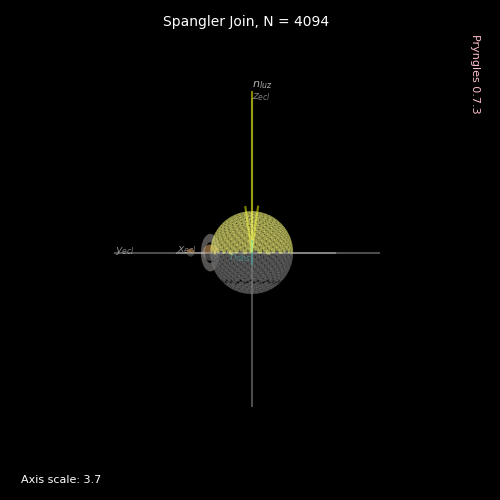

<IPython.core.display.Javascript object>


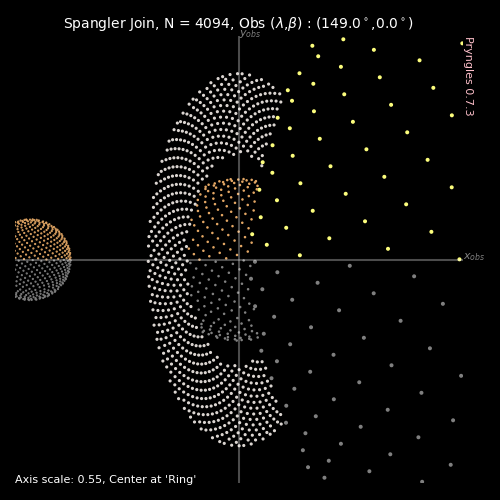

In [182]:
#sys.set_observer(n_obs=[-1,0.6,0])
sys.set_observer(n_obs=[-1,0.6,0])
sys.update_system_visibility()
sys.sp.set_luz(n_luz=[0,0,1])
#sys.sp.plot_obs(show_hidden=False)
#sys.sp.plot3d(center_at="Planet")
sys.sp.plot3d()
sys.sp.plot_obs(show_hidden=False,center_at="Ring")

Checking body Star (Star)
zmin = -0.9996436780478547, zmed = -1.4570387882932094e-06, zmax = 0.9992057860685891
Points above: 1411
Points below: 0
Checking body Planet (Planet)
zmin = 1.5889256463902612, zmed = 1.7888540905920736, zmax = 1.98869553921355
Points above: 0
Points below: 23
Checking body Moon (Planet)
zmin = 1.6289747533158312, zmed = 1.7289389754167346, zmax = 1.8288596997274755
Points above: 0
Points below: 3
Checking body Ring (Ring)
zmin = 1.583242902860988, zmed = 1.7888214333605716, zmax = 1.994564101121616
	Splitting ring in two parts
Up: 566
Down: 567
Points below middle up of ring: 27
Points below middle down of ring: 10


<IPython.core.display.Javascript object>


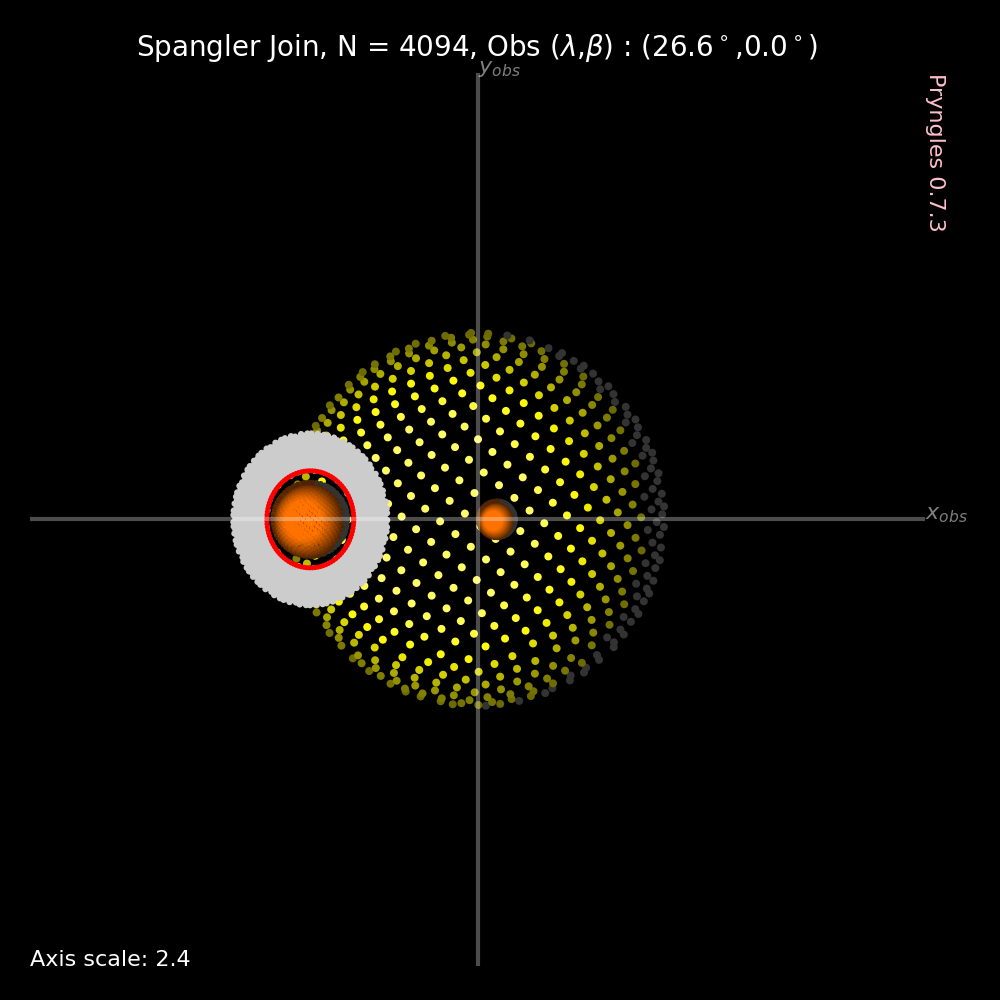

In [44]:
nspangles=1000
sys=System()
S=sys.add(hash="Star",nspangles=nspangles,m=8,radius=1,x=0,vy=2)
P=sys.add("Planet",primary=S,hash="Planet",nspangles=nspangles,radius=0.2,a=2)
M=sys.add("Planet",primary=P,hash="Moon",nspangles=nspangles,radius=0.1,a=1,M=120*Consts.deg)
R=sys.add("Ring",primary=P,hash="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=90*Consts.deg)
sys.spangle_system()
sys.set_observer(nvec=[1,0.5,0])
sys.update_system_visibility()
sys.sp.set_luz(nvec=[1,0,0])
sys.sp.plot_obs()

In [26]:
def condicion():
    cond=(sys.sp.data.body_hash!="Star")
    zobj=sys.sp.data[~cond]["z_obs"].mean()
    qhull=ConvexHull(sys.sp.data[~cond][["x_obs","y_obs"]])
    inhull=sci.points_in_hull(sys.sp.data[cond][["x_obs","y_obs"]],qhull)

    above=(inhull)&(sys.sp.data[cond]["z_obs"]>=zobj)
    below=(inhull)&(sys.sp.data[cond]["z_obs"]<=zobj)
    print(above.sum(),below.sum())

In [27]:
condicion()

0 2328


In [93]:
%timeit -n 10 condicion()

4.86 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [88]:
print(above.sum(),below.sum())

0 107


In [18]:
#Create a simple system
sys=System(units=["au","msun","yr"])
sys.sim.integrator='whfast'
sys.sim.dt=0.01
#Once you create a system, a null spangler is created 
"""
You may set the observer from the very beginning
"""
sys.set_observer(n_obs=[1,1,0],alpha_obs=0)

#Add star (by default, m = 1)
S=sys.add()

#Add planet, when an object is added, it is automatically spangled
P=sys.add("Planet",radius=0.1,m=1e-3,a=1,e=0.2)

#Add moon: orbital elements are respect to equatorial plane of the primary
M=sys.add("Planet",primary=P,radius=0.01,m=1e-7,a=0.1,e=0.01)

#Add ring system
R=sys.add("Ring",primary=P,fi=1.5,fe=2.5,albedo_gray_normal=0.5,tau_gray_optical=3)

#If you change the number of spangles of an object the spanglers are reset
sys.update_body(R,nspangles=800)

#Each time an object is updated, the spangler should be rejoined and the simulation reset.

#Spangle 
#sys.spangle_system()

#You may check separately the properties of each object
R.spangler.plot3d()
R.spangler.plot_obs()

#Plot
sys.spangler.plot3d()
sys.spangler.plot_obs()

AttributeError: 'System' object has no attribute 'set_observer'

In [ ]:
print(R)

In [ ]:
#Update properties of objects, even after the system is spangled
sys.update_body(S,limb_coeffs=[0.5,0.2])
sys.update_body(R,i=30*Consts.deg,roll=60*Consts.deg)
sys.update_body(P,Prot=24*Const.hour/sys.ul)

In [ ]:
sys.set_observer(n_obs=[1,1,1],alpha_obs=0)

In [ ]:
#When you integrate you update the position of the bodies, recalculate light sources, observer configuration and 
sys.sim_integrate(0.5)

sys.spangler.plot3d()
sys.spangler.plot_obs()

In [ ]:
sys.sim_reset()

In [ ]:
#Update positions: in this way you can move the planet, for instance, around the star
sys.update_body(R,M=30*Consts.deg)

In [ ]:
"""
You may integrate without calculating photometry

Once you're ready calculate photometry
"""
sys.calc_photometry()

In [ ]:
"""
This routine only update the optical states of the spangles
"""
sys._update_states()

"""
This routine update temperatures.  This take into account the illumination history of the spangles
"""
sys._update_temperatures()